In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import rc
rc('figure', figsize=(15, 5))
from timeit import default_timer as timer
import pickle
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Activation, Dropout, Reshape, Concatenate
from keras.layers.embeddings import Embedding
from keras.metrics import mean_squared_error
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
sales_test = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/test.csv')

In [0]:
def create_test(test):
    test = test.loc[(test['shop_id'].isin(sales_test['shop_id']))&(test['item_id'].isin(sales_test['item_id'])),:].copy()
    test_pred = test['cnt_shop_item'].copy()
    test.drop('cnt_shop_item', axis = 1, inplace = True)
    return(test, test_pred)

In [0]:
def create_cv_sets2(months, data):
    X_train = data.loc[~data['date_block_num'].isin(months+[34]),:].drop('cnt_shop_item', axis=1)
    X_val = data.loc[data['date_block_num'].isin(months),:]
    X_val, y_val = create_test(X_val)
    X_test = data.loc[data['date_block_num'] == 34,:].drop('cnt_shop_item',axis=1)
    y_train = data.loc[~data['date_block_num'].isin(months+[34]),'cnt_shop_item']
    return(dict({'train': X_train, 'val': X_val, 'test': X_test, 'train_y': y_train, 'val_y': y_val}))

In [0]:
def create_test_data(prediction, dict_cat):
  trtv = pd.concat([dict_cat['train'], dict_cat['val']], axis = 0)
  test_ids = dict_cat['test']['item_id'].isin(trtv['item_id']) & dict_cat['test']['shop_id'].isin(trtv['shop_id'])
  prediction[~test_ids] = 0
  return(prediction)

In [0]:
def create_submission_file(pred, name):
    ID = np.arange(0, sales_test.shape[0]) 
    new_df = pd.DataFrame({'ID': ID, 'item_cnt_month':pred[:,0]})
    new_df.to_csv('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/'+name+'.csv',index = False)

In [0]:
def plot_learning_curve(model):
  plt.plot(model.history.history['val_loss'], label = 'validation')
  plt.plot(model.history.history['loss'], label = 'training')
  plt.legend()
  plt.title('Learning Curve')
  return(plt)

In [0]:
with open(r"/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/full_data_2.pkl", "rb") as input_file:
    full_data = pickle.load(input_file)

In [0]:
dict_cat = create_cv_sets2([9,21,33], full_data)

In [0]:
n_feats = [i for i in dict_cat['train'].columns.tolist() if i not in ['date_block_num', 'shop_id', 'item_id', 
                                                                      'item_category_id', 'month', 'year']]
for feat in n_feats:
    scaler = StandardScaler()
    dict_cat['train'][feat] = scaler.fit_transform(dict_cat['train'][feat].values.reshape(-1,1))
    dict_cat['val'][feat] = scaler.transform(dict_cat['val'][feat].values.reshape(-1,1))
    dict_cat['test'][feat] = scaler.transform(dict_cat['test'][feat].values.reshape(-1,1))

In [0]:
order_of_var = [
    'date_block_num',
    
    'shop_id_enc_cnt_shop_item', 'shop_id_enc_cnt_shop',
    'shop_id_enc_cnt_item', 'shop_id_enc_cnt_itcat',
    
    'item_id_enc_cnt_shop_item', 'item_id_enc_cnt_shop',
    'item_id_enc_cnt_item', 'item_id_enc_cnt_itcat',
    
    'item_category_id_enc_cnt_shop_item', 'item_category_id_enc_cnt_shop',
    'item_category_id_enc_cnt_item', 'item_category_id_enc_cnt_itcat',
    
    'month_enc_cnt_shop_item', 'month_enc_cnt_shop', 
    'month_enc_cnt_item', 'month_enc_cnt_itcat', 
    
    'year_enc_cnt_shop_item', 'year_enc_cnt_shop',
    'year_enc_cnt_item', 'year_enc_cnt_itcat',
    
    'sales_shop_item_lag_1', 'price_shop_item_lag_1', 
    'sales_shop_item_lag_2', 'price_shop_item_lag_2',
    'cnt_shop_item_lag_1', 'cnt_shop_item_lag_2',
    'cnt_shop_item_lag_3', 'cnt_shop_item_lag_4',
    'cnt_shop_item_lag_5', 'cnt_shop_item_lag_6',
    'cnt_shop_item_lag_12',
    
    'sales_shop_lag_1', 'price_shop_lag_1',
    'sales_shop_lag_2', 'price_shop_lag_2',
    'cnt_shop_lag_1', 'cnt_shop_lag_2',
    'cnt_shop_lag_3', 'cnt_shop_lag_4',
    'cnt_shop_lag_5', 'cnt_shop_lag_6',
    'cnt_shop_lag_12',
    
    'sales_item_lag_1', 'price_item_lag_1', 
    'sales_item_lag_2', 'price_item_lag_2',
    'cnt_item_lag_1', 'cnt_item_lag_2',
    'cnt_item_lag_3', 'cnt_item_lag_4',
    'cnt_item_lag_5', 'cnt_item_lag_6',
    'cnt_item_lag_12',
    
    'sales_itcat_lag_1', 'price_itcat_lag_1', 
    'sales_itcat_lag_2', 'price_itcat_lag_2',
    'cnt_itcat_lag_1', 'cnt_itcat_lag_2',
    'cnt_itcat_lag_3', 'cnt_itcat_lag_4',
    'cnt_itcat_lag_5', 'cnt_itcat_lag_6',
    'cnt_itcat_lag_12',
    
    'item_name_1', 'item_name_2', 
    'item_name_3', 'item_name_4', 
    'item_name_5', 
    
    'item_category_name_1', 'item_category_name_2', 
    'item_category_name_3', 'item_category_name_4',
    'item_category_name_5']

In [12]:
len(order_of_var)

75

In [0]:
def create_emb_df(mat):
    df = mat.copy()
    df['month']-=1
    df['year']-=2013
    X = []
    cat_ind = ['shop_id', 'item_id', 'item_category_id', 'month', 'year']
    for feat in cat_ind:
        X.append(df[feat].values)
    df = df.drop(cat_ind, axis = 1)
    freq_cat = [1,4,4,4,4,4,11,11,11,11,5,5]
    curr = 0
    for i in freq_cat:
        X.append(df.iloc[:,curr:(curr+i)].values)
        curr+=i
    return(X)

In [0]:
nn_dict = dict()
for key in dict_cat.keys():
    nn_dict[key] = create_emb_df(dict_cat[key]) if 'y' not in key else dict_cat[key].values

###*Creating a dense embedding neural network without Item Ids*

In [0]:
for key in nn_dict.keys():
    if 'y' not in key: del nn_dict[key][1]

In [0]:
def make_model_dense():
    
    layers = []
    
    shop_id_in = Input((1,), name = 'shop_id_in')
    shop_id = Embedding(60,12)(shop_id_in)
    shop_id = Reshape((12,))(shop_id)
    layers.append(shop_id)
    
    itcat_id_in = Input((1,), name='itcat_in')
    itcat_id = Embedding(84,12)(itcat_id_in)
    itcat_id = Reshape((12,))(itcat_id)
    layers.append(itcat_id)
    
    month_in = Input((1,), name='month_in')
    month = Embedding(12,4)(month_in)
    month = Reshape((4,))(month)
    layers.append(month)
    
    year_in = Input((1,), name='year_in')
    year = Embedding(3,2)(year_in)
    year = Reshape((2,))(year)
    layers.append(year)
    
    date_block_in = Input((1,), name='date_block_in')
    date_block = Dense(1)(date_block_in)
    layers.append(date_block)
    
    shop_id_enc_in = Input((4,), name='shop_id_end_in')
    shop_id_enc = Dense(4)(shop_id_enc_in)
    layers.append(shop_id_enc)
    
    item_id_enc_in = Input((4,), name='item_id_end_in')
    item_id_enc = Dense(4)(item_id_enc_in)
    layers.append(item_id_enc)
    
    itcat_id_enc_in = Input((4,), name='itcat_id_end_in')
    itcat_id_enc = Dense(4)(itcat_id_enc_in)
    layers.append(itcat_id_enc)
    
    month_id_enc_in = Input((4,), name='month_id_end_in')
    month_id_enc = Dense(4)(month_id_enc_in)
    layers.append(month_id_enc)
    
    year_id_enc_in = Input((4,), name='year_id_end_in')
    year_id_enc = Dense(4)(year_id_enc_in)
    layers.append(year_id_enc)
    
    shop_item_lag_in = Input((11,), name='shop_item_lag_in')
    shop_item_lag = Dense(11)(shop_item_lag_in)
    layers.append(shop_item_lag)
    
    shop_lag_in = Input((11,), name='shop_lag_in')
    shop_lag = Dense(11)(shop_lag_in)
    layers.append(shop_lag)
    
    item_lag_in = Input((11,), name='item_lag_in')
    item_lag = Dense(11)(item_lag_in)
    layers.append(item_lag)
    
    itcat_lag_in = Input((11,), name='itcat_lag_in')
    itcat_lag = Dense(11)(itcat_lag_in)
    layers.append(itcat_lag)
    
    item_name_in = Input((5,),name='item_name_in')
    item_name = Dense(5)(item_name_in)
    layers.append(item_name)
    
    itcat_name_in = Input((5,), name='itcat_name_in')
    itcat_name = Dense(5)(itcat_name_in)
    layers.append(itcat_name)
    
    model = Concatenate()(layers)
    model = Dropout(0.02, seed = 24)(model)
    
    model = Dense(1500, name='fc1')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.2, seed = 24)(model)
    
    model = Dense(1000, name='fc2')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.2,seed = 24)(model)
    
    model = Dense(500, name='fc3')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.1,seed = 24)(model)
    
    model = Dense(150, name='fc4')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.1,seed = 24)(model)
    
    model = Dense(15,name='fc5')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Dropout(0.1,seed = 24)(model)
    
    model= Dense(1,name='fc6')(model)
    
    final_model = Model(inputs = [shop_id_in, itcat_id_in, month_in, year_in, date_block_in, shop_id_enc_in,
                                 item_id_enc_in, itcat_id_enc_in, month_id_enc_in, year_id_enc_in, shop_item_lag_in,
                                 shop_lag_in, item_lag_in, itcat_lag_in, item_name_in, itcat_name_in],
                       outputs = model,
                       name = 'nn_enc_dense_pfs4')
    return(final_model)

In [40]:
model = make_model_dense()
model.compile('Adam', loss = 'mean_squared_error')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shop_id_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
itcat_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
month_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
year_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
check_point = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep2.hdf5', monitor='val_loss', verbose=5, save_best_only=True)
model.fit(x = nn_dict['train'], y = nn_dict['train_y'], batch_size=2048, epochs=100, 
          validation_data=(nn_dict['val'], nn_dict['val_y']), callbacks = [check_point, early_stopping])

Train on 1483908 samples, validate on 59742 samples
Epoch 1/100
1483908/1483908 [==============================] - 51s 35us/step - loss: 3.1268 - val_loss: 2.8461

Epoch 00001: val_loss improved from inf to 2.84610, saving model to /content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep2.hdf5
Epoch 2/100
1483908/1483908 [==============================] - 49s 33us/step - loss: 2.5461 - val_loss: 2.5751

Epoch 00002: val_loss improved from 2.84610 to 2.57512, saving model to /content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep2.hdf5
Epoch 3/100
1483908/1483908 [==============================] - 48s 32us/step - loss: 2.4348 - val_loss: 2.5225

Epoch 00003: val_loss improved from 2.57512 to 2.52250, saving model to /content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep2.hdf5
Epoch 4/100
1483908/1483908 [==============================] - 48s 32us/step - loss: 2.3520 - val_loss: 2.4837

Epoch 00004: val_loss improved from 

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_last_model_bn_dp_deep.hdf')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

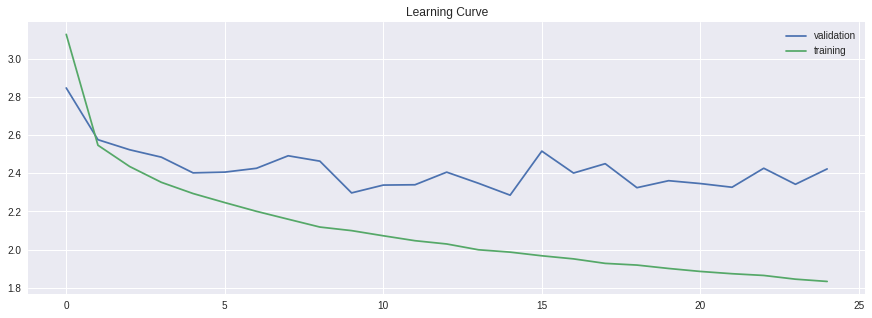

In [44]:
plot_learning_curve(model)

### Loading the best model and getting predictions for the test set

In [0]:
from keras.models import load_model

In [0]:
model = load_model('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/nn_bn_dp_deep.hdf5')

In [0]:
pred = model.predict(nn_dict['test'])

In [0]:
pred = pred-1
prediction = create_test_data(pred, dict_cat)
create_submission_file(prediction, 'nn_pred_final')

Get predictions for month 28 to 33 for training set of stacking

In [0]:
stack_months = np.arange(28,34)

In [0]:
stack_y = full_data.loc[full_data['date_block_num'].isin(stack_months),'cnt_shop_item']

In [0]:
stack_x = []
for i in stack_months:
  data_train_x = full_data.loc[full_data['date_block_num']<i,:].copy()
  data_train_y = full_data.loc[full_data['date_block_num']==i,:].copy()
  data_train_x.drop('cnt_shop_item', axis = 1, inplace = True)
  data_train_y.drop('cnt_shop_item', axis = 1, inplace = True)
  scaler = StandardScaler()
  data_x = data_train_x.copy()
  data_y = data_train_y.copy()
  for feat in n_feats:
    scaler = StandardScaler()
    data_x[feat] = scaler.fit_transform(data_train_x[feat].values.reshape(-1,1))
    data_y[feat] = scaler.transform(data_train_y[feat].values.reshape(-1,1))
  data_emb_x = create_emb_df(data_x)
  data_emb_y = create_emb_df(data_y)
  del data_emb_x[1], data_emb_y[1]
  data_train_y = full_data.loc[full_data['date_block_num']<i,'cnt_shop_item'].copy()
  data_test_y = full_data.loc[full_data['date_block_num']==i,'cnt_shop_item'].copy()
  
  # Start training
  print('training for month', i)
  model_stack = make_model_dense()
  model_stack.compile('Adam', loss='mean_squared_error')
  model_stack.fit(data_emb_x, data_train_y, epochs = 14, batch_size = 2048)
  stack_x.extend(np.squeeze(model_stack.predict(data_emb_y)).tolist())

In [0]:
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/Stacking/emb_nn_train_level2.csv', stack_x, delimiter = ',')

Combine train and validation sets to get test set for stacking

In [0]:
stack_train = pd.concat([dict_cat['train'], dict_cat['val']], axis = 0)
stack_train_y = pd.concat([dict_cat['train_y'], dict_cat['val_y']], axis = 0)
stack_x = create_emb_df(stack_train)
del stack_x[1]

In [19]:
model_stack = make_model_dense()
model_stack.compile('Adam', loss = 'mean_squared_error')
model_stack.fit(stack_x, stack_train_y, epochs = 14, batch_size = 2048)

Epoch 1/14
1543650/1543650 [==============================] - 48s 31us/step - loss: 2.9767
Epoch 2/14
1543650/1543650 [==============================] - 45s 29us/step - loss: 2.5580
Epoch 3/14
1543650/1543650 [==============================] - 45s 29us/step - loss: 2.4414
Epoch 4/14
1543650/1543650 [==============================] - 45s 29us/step - loss: 2.3569
Epoch 5/14
1543650/1543650 [==============================] - 45s 29us/step - loss: 2.2970
Epoch 6/14
1543650/1543650 [==============================] - 45s 29us/step - loss: 2.2440
Epoch 7/14
1543650/1543650 [==============================] - 45s 29us/step - loss: 2.2039
Epoch 8/14
1543650/1543650 [==============================] - 45s 29us/step - loss: 2.1625
Epoch 9/14
1543650/1543650 [==============================] - 46s 29us/step - loss: 2.1279
Epoch 10/14
1543650/1543650 [==============================] - 45s 29us/step - loss: 2.0995
Epoch 11/14
1543650/1543650 [==============================] - 45s 29us/step - loss: 2.07

In [0]:
model_stack = load_model('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/Stacking/emb_nn_final_model.hdf')

In [0]:
stack_test_level2_pred = model_stack.predict(nn_dict['test'])

In [0]:
stack_test_level2_x = stack_test_level2_pred-1
stack_test_level2_x = [0 if i<0 else i for i in stack_test_level2_x]
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/Stacking/emb_nn_test_level2_2.csv', stack_test_level2_x, delimiter = ',')

In [0]:
model_stack.save('/content/gdrive/My Drive/Colab Notebooks/Time_series_prediction/Stacking/emb_nn_final_model.hdf')

In [0]:
create_submission_file(np.array(stack_test_level2_x)[:,np.newaxis], 'nn_pred_final')